Since your task involves **Applied Machine Learning**, let’s break it down into clear steps:

### **1. Understanding the Dataset**
- Load the dataset
- Check for missing values (even though we know there are none)
- Explore basic statistics (mean, standard deviation, etc.)
- Visualize distributions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116 entries, 0 to 115
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             116 non-null    int64  
 1   BMI             116 non-null    float64
 2   Glucose         116 non-null    int64  
 3   Insulin         116 non-null    float64
 4   HOMA            116 non-null    float64
 5   Leptin          116 non-null    float64
 6   Adiponectin     116 non-null    float64
 7   Resistin        116 non-null    float64
 8   MCP.1           116 non-null    float64
 9   Classification  116 non-null    int64  
dtypes: float64(7), int64(3)
memory usage: 9.2 KB
None
              Age         BMI     Glucose     Insulin        HOMA      Leptin  \
count  116.000000  116.000000  116.000000  116.000000  116.000000  116.000000   
mean    57.301724   27.582111   97.793103   10.012086    2.694988   26.615080   
std     16.112766    5.020136   22.525162   10.067768    

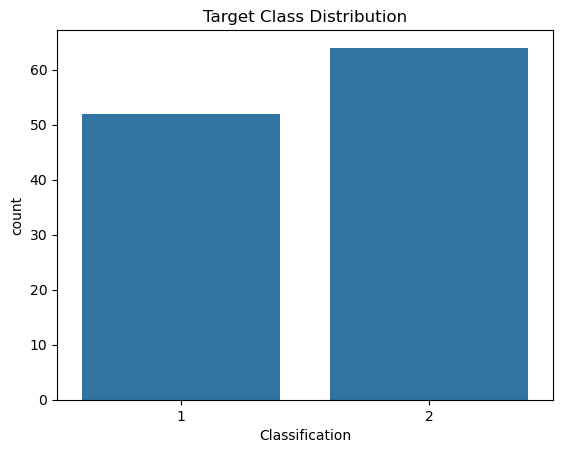

Missing values per column:
 Age               0
BMI               0
Glucose           0
Insulin           0
HOMA              0
Leptin            0
Adiponectin       0
Resistin          0
MCP.1             0
Classification    0
dtype: int64


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
file_path = "dataR2.csv"  # Adjust this if running locally
df = pd.read_csv(file_path)

# Display basic info
print(df.info())
print(df.describe())

# Check class distribution
sns.countplot(x="Classification", data=df)
plt.title("Target Class Distribution")
plt.show()

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())


### **2. Preprocessing**
- Encode the target variable (convert 1/2 into 0/1 for binary classification)
- Scale the features (important for algorithms like logistic regression, SVM, and neural networks)
- Split data into training and test sets

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import cross_val_score


# Encode the target variable (1 -> 0, 2 -> 1)
df["Classification"] = df["Classification"].map({1: 0, 2: 1})

# Separate features and target
X = df.drop(columns=["Classification"])
y = df["Classification"]

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


### **3. Applying Machine Learning**
- Train baseline models (e.g., Logistic Regression, Decision Tree, Random Forest, SVM, etc.)
- Evaluate performance using accuracy, precision, recall, F1-score
- Tune hyperparameters with GridSearchCV or RandomizedSearchCV

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Train multiple models using 5-fold cross-validation
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True)
}

for name, model in models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')
    print(f"Model: {name}")
    print("Cross-validated Accuracy scores:", scores)
    print("Mean Accuracy:", scores.mean())
    print("Standard Deviation:", scores.std())
    print("="*50)


Model: Logistic Regression
Cross-validated Accuracy scores: [0.66666667 0.60869565 0.60869565 0.7826087  0.47826087]
Mean Accuracy: 0.6289855072463768
Standard Deviation: 0.09855072463768116
Model: Random Forest
Cross-validated Accuracy scores: [0.54166667 0.7826087  0.7826087  0.73913043 0.56521739]
Mean Accuracy: 0.6822463768115942
Standard Deviation: 0.1066202837087327
Model: SVM
Cross-validated Accuracy scores: [0.70833333 0.56521739 0.82608696 0.73913043 0.47826087]
Mean Accuracy: 0.6634057971014493
Standard Deviation: 0.12500997649748816


### **4. Feature Selection & Engineering**
- Check feature importance using techniques like mutual information or correlation
- Try PCA (Principal Component Analysis) if dimensionality reduction is needed

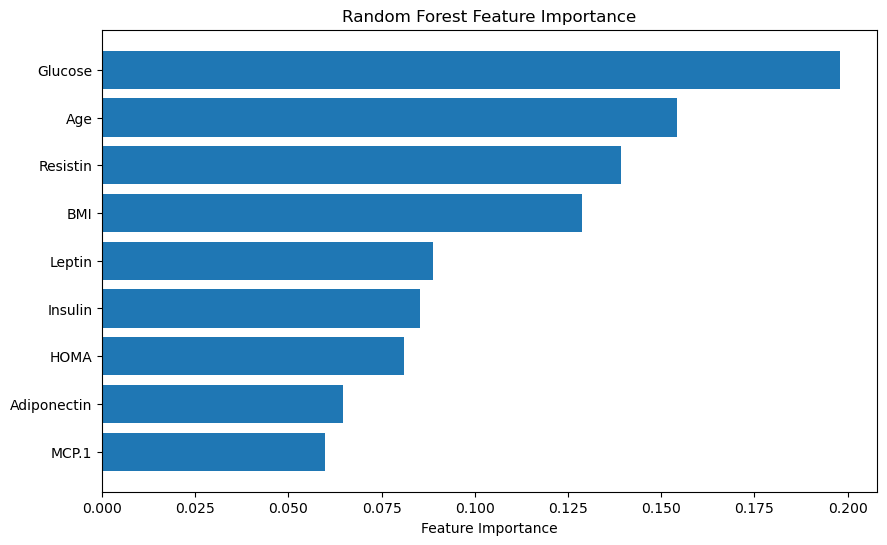

In [7]:
# Fit a new Random Forest model on the full dataset for feature importance only
rf_model = RandomForestClassifier()
rf_model.fit(X_scaled, y)

# Now access feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort and plot
sorted_idx = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(feature_names)[sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


### **5. Model Evaluation & Interpretation**
- Use confusion matrix, ROC curve, and classification reports
- Explain predictions using SHAP or LIME

In [8]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Random Forest
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_search.fit(X_scaled, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)



Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Accuracy: 0.725


### **6 ROC Curve & Confusion Matrix**

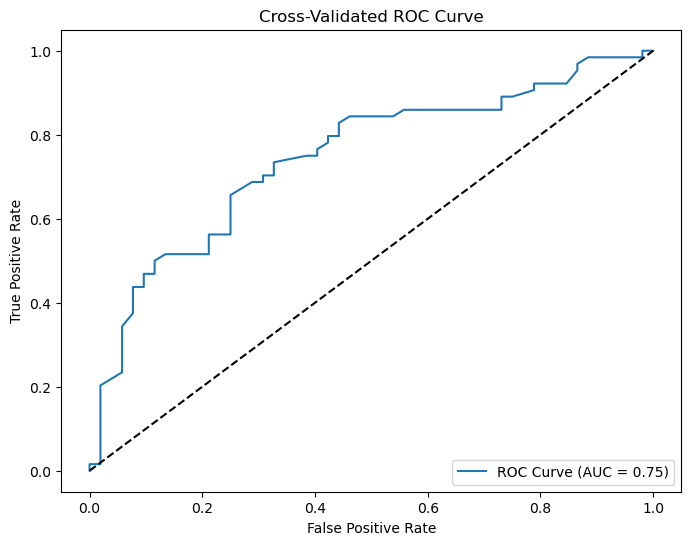

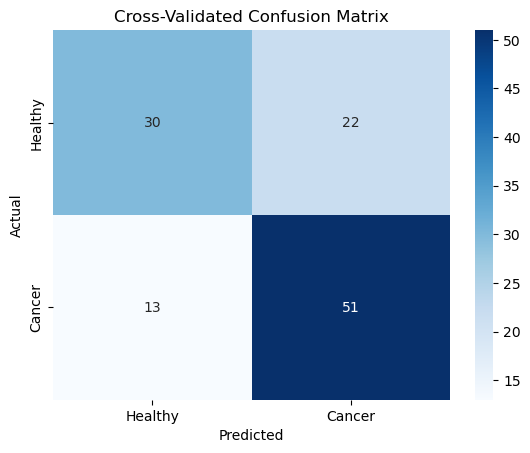

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc, confusion_matrix, RocCurveDisplay

# Get cross-validated prediction probabilities
rf_model = RandomForestClassifier(**grid_search.best_params_)  # use tuned model if you want
y_probs = cross_val_predict(rf_model, X_scaled, y, cv=5, method='predict_proba')[:, 1]
y_pred = (y_probs >= 0.5).astype(int)  # convert probs to class predictions

# Compute ROC curve
fpr, tpr, _ = roc_curve(y, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Cross-Validated ROC Curve")
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Cancer"], yticklabels=["Healthy", "Cancer"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Cross-Validated Confusion Matrix")
plt.show()
